<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>


#### Classify handwritten digits using the famous MNIST data

The goal in this task is to take an image of a handwritten single digit, and determine what that digit is.  

The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import Image
from IPython.core.display import HTML

In [2]:
print(tf.__version__)

2.3.1


In [3]:
datapath = "../../../data/"
outputs = "../../../data/"

In [4]:
# read training data from CSV file 

with ZipFile(os.path.join(datapath, 'kaggle_digits_train.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_train.csv') as myfile:
        train_data = pd.read_csv(myfile)
        
with ZipFile(os.path.join(datapath, 'kaggle_digits_test.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_test.csv') as myfile:
        test_data = pd.read_csv(myfile)

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [5]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images numpy array have shape: ({0[0]},{0[1]})'.format(images.shape))

images numpy array have shape: (42000,784)


In [6]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


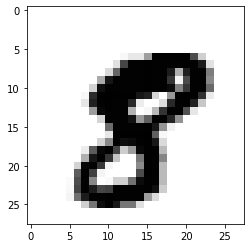

In [8]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [9]:
labels_flat = train_data.iloc[:,0].values

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


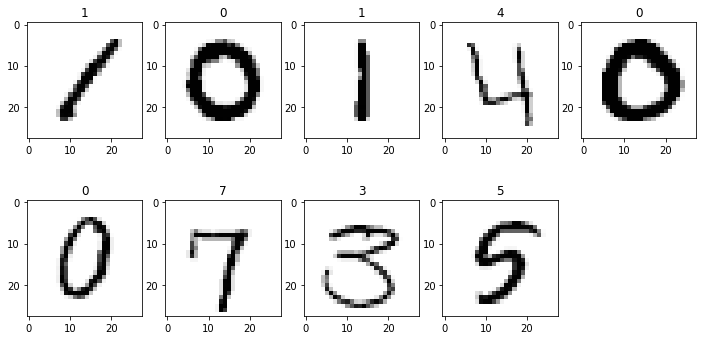

In [10]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = images[i,:].reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(labels_flat[i])

In [11]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [12]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_images = test_data.values.astype(np.float)
test_images.shape

(28000, 784)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels_flat, 
                                                                    test_size=0.4, 
                                                                    random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200,))
validation labels((16800,))


In [15]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

0.9611904761904762


In [16]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.9720833333333333


Making Predictions

In [17]:
predict_rf = clf_rf.predict(test_images)
predict_rf[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [18]:
predict_svm = clf_svm.predict(test_images)
predict_svm[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

### Using Tensor Flow (with a fully connected ANN)

In [19]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.3.1


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


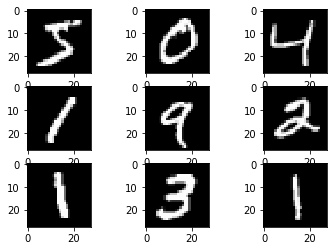

In [20]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [21]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [22]:
%time model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 1s 598us/step - loss: 0.2940 - accuracy: 0.9144
Epoch 2/10
1875/1875 [==============================] - 1s 557us/step - loss: 0.1457 - accuracy: 0.9567
Epoch 3/10
1875/1875 [==============================] - 1s 562us/step - loss: 0.1079 - accuracy: 0.9673
Epoch 4/10
1875/1875 [==============================] - 1s 566us/step - loss: 0.0861 - accuracy: 0.9733
Epoch 5/10
1875/1875 [==============================] - 1s 578us/step - loss: 0.0738 - accuracy: 0.9761
Epoch 6/10
1875/1875 [==============================] - 1s 567us/step - loss: 0.0651 - accuracy: 0.9795
Epoch 7/10
1875/1875 [==============================] - 1s 582us/step - loss: 0.0581 - accuracy: 0.9811
Epoch 8/10
1875/1875 [==============================] - 1s 579us/step - loss: 0.0540 - accuracy: 0.9829
Epoch 9/10
1875/1875 [==============================] - 1s 570us/step - loss: 0.0488 - accuracy: 0.9843
Epoch 10/10
1875/1875 [==============================] - 1s 601u

[0.08155983686447144, 0.9775000214576721]

### Using Tensor Flow (with a CNN)

### a) simple model

In [23]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# baseline cnn model for mnist

(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)
# scale pixels
trainX, testX = prep_pixels(trainX, testX)



model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu', 
                                                           kernel_initializer='he_uniform', 
                                                           input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
                                    tf.keras.layers.Dense(10, activation='softmax'),
                                   ])

model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [24]:
%time model.fit(trainX, trainY, epochs=10)
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1439 - accuracy: 0.9563
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0485 - accuracy: 0.9850
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0291 - accuracy: 0.9912
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0186 - accuracy: 0.9938
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0131 - accuracy: 0.9957
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0094 - accuracy: 0.9969
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0064 - accuracy: 0.9977
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0068 - accuracy: 0.9976
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.004

[0.06961658596992493, 0.9846000075340271]

### b) slightly bigger model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1)
                                ))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY,batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1781 - accuracy: 0.9462 - val_loss: 0.0497 - val_accuracy: 0.9828
Epoch 2/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0770 - accuracy: 0.9770 - val_loss: 0.0336 - val_accuracy: 0.9884
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 4/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0471 - accuracy: 0.9854 - val_loss: 0.0281 - val_accuracy: 0.9903
Epoch 5/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0407 - accuracy: 0.9868 - val_loss: 0.0282 - val_accuracy: 0.9909
Epoch 6/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.0261 - val_accuracy: 0.9926
Epoch 7/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0302 - accuracy: 0.9903 - val_loss: 0.0350 -

[0.02999025024473667, 0.991599977016449]

In [28]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0300 - accuracy: 0.9916
Test loss: 0.02999025024473667
Test accuracy: 0.991599977016449


In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.178059,0.946233,0.049665,0.9828
1,0.076956,0.976983,0.033603,0.9884
2,0.059371,0.982233,0.038114,0.9875
3,0.047134,0.985433,0.028083,0.9903
4,0.040666,0.986833,0.028205,0.9909


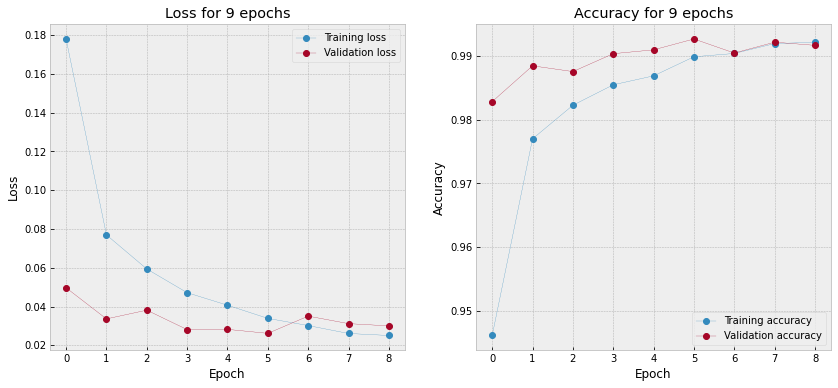

In [30]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### c) [Using the LENET architecture](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/  )

![](../../../images/lenet_architecture-768x226.png)

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.  

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.  

However, if you do have GPU support and can access your GPU via Keras, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).  

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=20, kernel_size = (5, 5), padding = "same", input_shape = (28, 28, 1)))
model.add(tf.keras.layers.Activation(activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides =  (2, 2)))
model.add(tf.keras.layers.Convolution2D(filters=50, kernel_size = (5, 5), padding = "same"))
model.add(tf.keras.layers.Activation(activation= "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500))
model.add(tf.keras.layers.Activation(activation = "relu"))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation("softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)             

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])

model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1079 - accuracy: 0.9665 - val_loss: 0.0350 - val_accuracy: 0.9899
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0378 - accuracy: 0.9880 - val_loss: 0.0298 - val_accuracy: 0.9904
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0334 - val_accuracy: 0.9903
Epoch 4/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0189 - accuracy: 0.9939 - val_loss: 0.0247 - val_accuracy: 0.9924
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0320 - val_accuracy: 0.9897
Epoch 6/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0305 - val_accuracy: 0.9906
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0314 -

[0.031357068568468094, 0.9921000003814697]

In [33]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0314 - accuracy: 0.9921
Test loss: 0.031357068568468094
Test accuracy: 0.9921000003814697


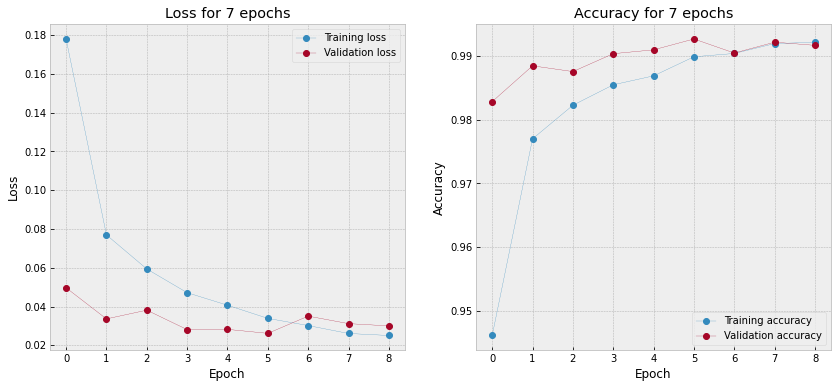

In [34]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### d) Testing a more complex model

![](https://sihamtabik.github.io/LeNet-like-CNN.jpg)

In [35]:
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=(28, 28, 1),))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)       

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.1567 - accuracy: 0.9492 - val_loss: 0.0478 - val_accuracy: 0.9856
Epoch 2/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0538 - accuracy: 0.9842 - val_loss: 0.0429 - val_accuracy: 0.9887
Epoch 3/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0394 - val_accuracy: 0.9869
Epoch 4/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0330 - accuracy: 0.9901 - val_loss: 0.0401 - val_accuracy: 0.9878
Epoch 5/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0321 - val_accuracy: 0.9916
Epoch 6/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0245 - val_accuracy: 0.9918
Epoch 7/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0242 - accuracy: 0.9933 - val_loss: 0.0285

[0.03233949467539787, 0.9926999807357788]

In [37]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 10ms/step - loss: 0.0323 - accuracy: 0.9927
Test loss: 0.03233949467539787
Test accuracy: 0.9926999807357788


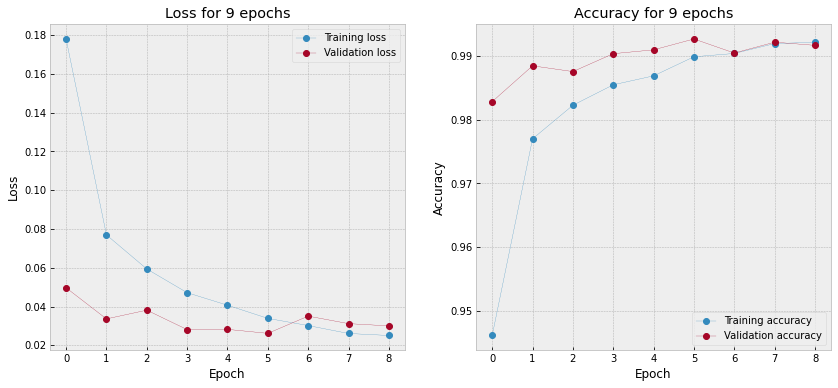

In [38]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Pre-trained models  

How can I use pre-trained models in Keras?  
Code and pre-trained weights are available for the following image classification models:  
+ Xception  
+ VGG16  
+ VGG19  
+ ResNet50  
+ Inception v3  

They can be imported from the module [keras.applications](https://keras.io/applications/):

In [39]:
#from keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

#model = VGG16(weights='imagenet', include_top=True)

[Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)
[Visualizing the classification task:](http://scs.ryerson.ca/~aharley/vis/fc/)